In [2]:

#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD



import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import tensorflow as tf 
print ("Done")

ModuleNotFoundError: No module named 'librosa'

# Importing Data 

                                              Ravdess Dataframe
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4 This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [69]:
#preparing data set

ravdess = 'audiodata/ravdess/audio_speech_actors_01-24/'

ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)

['Actor_16', 'Actor_11', 'Actor_18', 'Actor_20', 'Actor_21', 'Actor_19', 'Actor_10', 'Actor_17', '.DS_Store', 'Actor_04', 'Actor_03', 'Actor_02', 'Actor_05', 'Actor_12', 'Actor_15', 'Actor_23', 'Actor_24', 'Actor_22', 'Actor_14', 'Actor_13', 'Actor_09', 'Actor_07', 'Actor_06', 'Actor_01', 'Actor_08']


In [70]:
Crema = "audiodata/AudioWAV/"
Tess = "audiodata/TESS/TESS Toronto emotional speech set data/"
Savee = "audiodata/savee/"

# preprocessing

**Ravdees**

In [71]:
file_emotion = []
file_path = []

for i in ravdess_directory_list:
    actor_path = os.path.join(ravdess, i)
    if os.path.isdir(actor_path):
        actor = os.listdir(actor_path)
        for f in actor:
            if f.endswith('.wav'):  
                part = f.split('.')[0].split('-')
                file_emotion.append(int(part[2]))
                file_path.append(os.path.join(actor_path, f))
    else:
        print(f"Skipping non-directory item: {actor_path}")

print(file_emotion[:5])
print(file_path[:5])

Skipping non-directory item: audiodata/ravdess/audio_speech_actors_01-24/.DS_Store
[5, 6, 6, 5, 7]
['audiodata/ravdess/audio_speech_actors_01-24/Actor_16/03-01-05-01-02-01-16.wav', 'audiodata/ravdess/audio_speech_actors_01-24/Actor_16/03-01-06-01-02-02-16.wav', 'audiodata/ravdess/audio_speech_actors_01-24/Actor_16/03-01-06-02-01-02-16.wav', 'audiodata/ravdess/audio_speech_actors_01-24/Actor_16/03-01-05-02-01-01-16.wav', 'audiodata/ravdess/audio_speech_actors_01-24/Actor_16/03-01-07-01-01-01-16.wav']


In [73]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# changing integers to actual emotions.
ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',
                             8:'surprise'},
                            inplace=True)
print(ravdess_df.head())
print("______________________________________________")
print(ravdess_df.tail())
print("_______________________________________________")
print(ravdess_df.Emotions.value_counts())



  Emotions                                               Path
0    angry  audiodata/ravdess/audio_speech_actors_01-24/Ac...
1     fear  audiodata/ravdess/audio_speech_actors_01-24/Ac...
2     fear  audiodata/ravdess/audio_speech_actors_01-24/Ac...
3    angry  audiodata/ravdess/audio_speech_actors_01-24/Ac...
4  disgust  audiodata/ravdess/audio_speech_actors_01-24/Ac...
______________________________________________
     Emotions                                               Path
1435    happy  audiodata/ravdess/audio_speech_actors_01-24/Ac...
1436    happy  audiodata/ravdess/audio_speech_actors_01-24/Ac...
1437  neutral  audiodata/ravdess/audio_speech_actors_01-24/Ac...
1438  neutral  audiodata/ravdess/audio_speech_actors_01-24/Ac...
1439  neutral  audiodata/ravdess/audio_speech_actors_01-24/Ac...
_______________________________________________
Emotions
neutral     288
angry       192
fear        192
disgust     192
sad         192
surprise    192
happy       192
Name: count, dtype: in

**Crema DataFrame**

CREMA-D is a data set of 7,442 original clips from 91 actors. These clips were from 48 male and 43 female actors between the ages of 20 and 74 coming from a variety of races and ethnicities (African America, Asian, Caucasian, Hispanic, and Unspecified). Actors spoke from a selection of 12 sentences. The sentences were presented using one of six different emotions (Anger, Disgust, Fear, Happy, Neutral, and Sad) and four different emotion levels (Low, Medium, High, and Unspecified).

In [74]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df.Emotions.value_counts())


Emotions
angry      1271
disgust    1271
sad        1271
fear       1271
happy      1271
neutral    1087
Name: count, dtype: int64


**TESS dataset**

There are a set of 200 target words were spoken in the carrier phrase "Say the word _' by two actresses (aged 26 and 64 years) and recordings were made of the set portraying each of seven emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). There are 2800 data points (audio files) in total.

The dataset is organised such that each of the two female actor and their emotions are contain within its own folder. And within that, all 200 target words audio file can be found. The format of the audio file is a WAV format

In [75]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []


for dir in tess_directory_list:
    dir_path = os.path.join(Tess, dir)
    if os.path.isdir(dir_path):
        directories = os.listdir(dir_path)
        for file in directories:
            file_path_complete = os.path.join(dir_path, file)
            part = file.split('.')[0]
            part = part.split('_')[2]
            if part == 'ps':
                file_emotion.append('surprise')
            else:
                file_emotion.append(part)
            file_path.append(file_path_complete)
    else:
        print(f"Skipping non-directory item: {dir_path}")

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])

Tess_df = pd.concat([emotion_df, path_df], axis=1)

print(Tess_df.head())
print(Tess_df.Emotions.value_counts())

  Emotions                                               Path
0  disgust  audiodata/TESS/TESS Toronto emotional speech s...
1  disgust  audiodata/TESS/TESS Toronto emotional speech s...
2  disgust  audiodata/TESS/TESS Toronto emotional speech s...
3  disgust  audiodata/TESS/TESS Toronto emotional speech s...
4  disgust  audiodata/TESS/TESS Toronto emotional speech s...
Emotions
disgust     400
surprise    400
happy       400
sad         400
neutral     400
fear        400
angry       400
Name: count, dtype: int64


**SAVEE Dataset**

Context
The SAVEE database was recorded from four native English male speakers (identified as DC, JE, JK, KL), postgraduate students and researchers at the University of Surrey aged from 27 to 31 years. Emotion has been described psychologically in discrete categories: anger, disgust, fear, happiness, sadness and surprise. This is supported by the cross-cultural studies of Ekman [6] and studies of automatic emotion recognition tended to focus on recognizing these [12]. We added neutral to provide recordings of 7 emotion categories. The text material consisted of 15 TIMIT sentences per emotion: 3 common, 2 emotion-specific and 10 generic sentences that were different for each emotion and phonetically-balanced. The 3 common and 2 × 6 = 12 emotion-specific sentences were recorded as neutral to give 30 neutral sentences.

Content
This results in a total of 120 utterances per speaker, for example:

Common: She had your dark suit in greasy wash water all year.
Anger: Who authorized the unlimited expense account?
Disgust: Please take this dirty table cloth to the cleaners for me.
Fear: Call an ambulance for medical assistance.
Happiness: Those musicians harmonize marvelously.
Sadness: The prospect of cutting back spending is an unpleasant one for any governor.
Surprise: The carpet cleaners shampooed our oriental rug.
Neutral: The best way to learn is to solve extra problems.

In [76]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()
print(Savee_df.Emotions.value_counts())


Emotions
neutral     120
sad          60
surprise     60
fear         60
disgust      60
happy        60
angry        60
Name: count, dtype: int64


**Integration**

In [77]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,angry,audiodata/ravdess/audio_speech_actors_01-24/Ac...
1,fear,audiodata/ravdess/audio_speech_actors_01-24/Ac...
2,fear,audiodata/ravdess/audio_speech_actors_01-24/Ac...
3,angry,audiodata/ravdess/audio_speech_actors_01-24/Ac...
4,disgust,audiodata/ravdess/audio_speech_actors_01-24/Ac...


In [78]:
print(data_path.Emotions.value_counts())


Emotions
angry       1923
fear        1923
disgust     1923
sad         1923
happy       1923
neutral     1895
surprise     652
Name: count, dtype: int64


>*                           Data Visualisation and Exploration

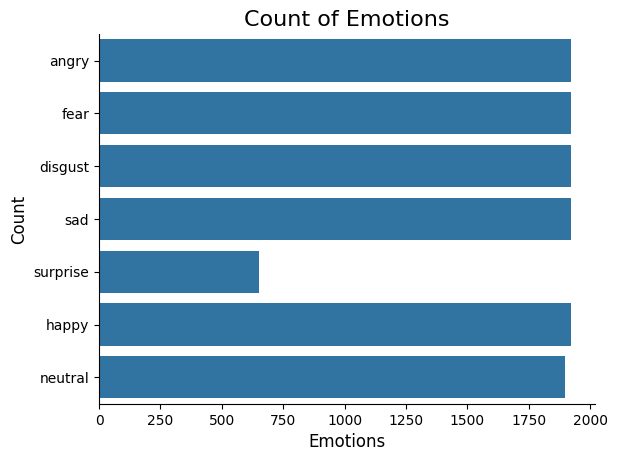

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [80]:
data,sr = librosa.load(file_path[0])
sr

22050

In [81]:
ipd.Audio(data,rate=sr)

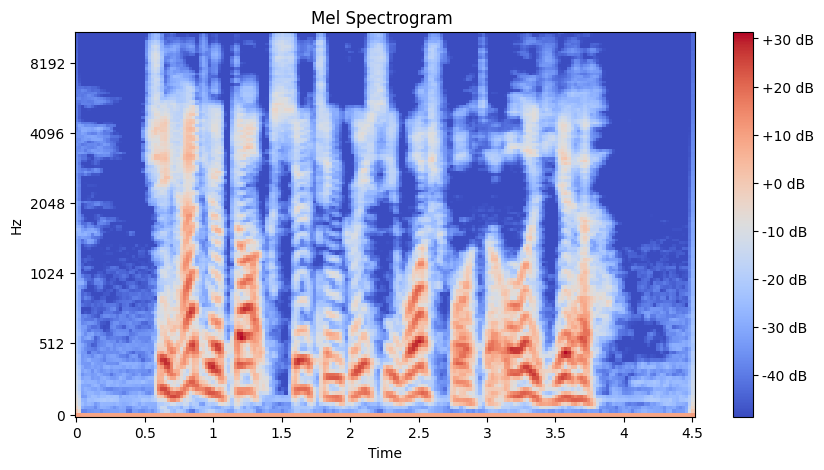

In [82]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB');

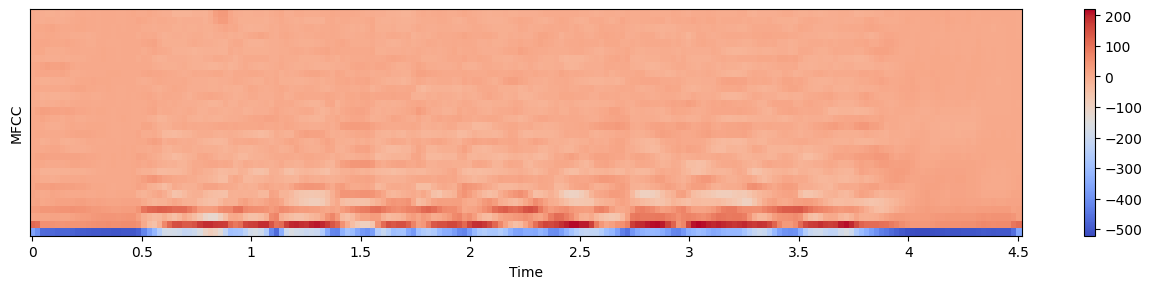

In [83]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)


# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(data,rate=sr)

# Data augmentation

In [1]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

In [3]:
# NORMAL AUDIO


import librosa.display
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sr)
# librosa.display.waveplot(y=data, sr=sr)

ipd.Audio(data,rate=sr)

ModuleNotFoundError: No module named 'librosa'

In [86]:
# # AUDIO WITH NOISE
# x = noise(data)
# plt.figure(figsize=(12,5))
# librosa.display.waveshow(y=x, sr=sr)
# ipd.Audio(x, rate=sr)

In [87]:
# # STRETCHED AUDIO
# x = stretch(data)
# plt.figure(figsize=(12, 5))
# librosa.display.waveshow(y=x, sr=sr)
# ipd.Audio(x, rate=sr)

In [88]:
# # SHIFTED AUDIO
# x = shift(data)
# plt.figure(figsize=(12,5))
# librosa.display.waveshow(y=x, sr=sr)
# ipd.Audio(x, rate=sr)

In [89]:
# # AUDIO WITH PITCH
# x = pitch(data, sr)
# plt.figure(figsize=(12, 5))
# librosa.display.waveshow(y=x, sr=sr)
# ipd.Audio(x, rate=sr)

# Feature extraction

In [90]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
# def rmse(data,frame_length=2048,hop_length=512):
#     rmse=librosa.feature.rms(data,frame_length=frame_length,hop_length=hop_length)
#     return np.squeeze(rmse)
def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    # mfcc=librosa.feature.mfcc(data,sr=sr)
    mfcc = librosa.feature.mfcc(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)  # 示例中使用20个MFCC特征

    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])
    
    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)
    
    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))
    
    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))
    
    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))
    
    return audio


In [91]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  8


# Normal way to get features

In [92]:
import timeit
from tqdm import tqdm
start = timeit.default_timer()
X,Y=[],[]
for path,emotion,index in tqdm (zip(data_path.Path,data_path.Emotions,range(data_path.Path.shape[0]))):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)         

2it [00:00, 12.94it/s]

0 audio has been processed


503it [00:24, 21.26it/s]

500 audio has been processed


1004it [00:46, 22.11it/s]

1000 audio has been processed


1504it [01:09, 26.44it/s]

1500 audio has been processed


2006it [01:27, 27.83it/s]

2000 audio has been processed


2505it [01:46, 27.76it/s]

2500 audio has been processed


3005it [02:04, 27.67it/s]

3000 audio has been processed


3504it [02:22, 28.14it/s]

3500 audio has been processed


4003it [02:40, 26.81it/s]

4000 audio has been processed


4505it [02:58, 27.88it/s]

4500 audio has been processed


5004it [03:16, 29.31it/s]

5000 audio has been processed


5505it [03:34, 28.39it/s]

5500 audio has been processed


6004it [03:52, 28.03it/s]

6000 audio has been processed


6506it [04:10, 27.32it/s]

6500 audio has been processed


7004it [04:28, 27.01it/s]

7000 audio has been processed


7505it [04:46, 29.40it/s]

7500 audio has been processed


8004it [05:03, 27.78it/s]

8000 audio has been processed


8505it [05:21, 29.87it/s]

8500 audio has been processed


9005it [05:39, 27.81it/s]

9000 audio has been processed


9507it [05:55, 30.57it/s]

9500 audio has been processed


10007it [06:10, 33.89it/s]

10000 audio has been processed


10506it [06:23, 26.58it/s]

10500 audio has been processed


11007it [06:37, 32.65it/s]

11000 audio has been processed


11506it [06:54, 27.18it/s]

11500 audio has been processed


12004it [07:13, 24.69it/s]

12000 audio has been processed


12162it [07:20, 27.63it/s]

Done
Time:  440.2565900000045


# Faster way to get features
***Parallel way***

**Dont be afraid from red lines that Normal**


This code is an example of how to use the joblib library to process multiple audio files in parallel using the process_feature function. The code also uses the timeit library to measure the time taken to process the audio files.

Here's a breakdown of what the code does:

The from joblib import Parallel, delayed statement imports the Parallel and delayed functions from the joblib library.
The start = timeit.default_timer() statement starts a timer to measure the time taken to process the audio files.
The process_feature function processes a single audio file by extracting its features using the get_feat function and appending the corresponding X and Y values to the X and Y lists.
The paths and emotions variables extract the paths and emotions from the data_path DataFrame.
The Parallel function runs the process_feature function in parallel for each audio file using the delayed function to wrap the process_feature function.
The results variable contains the X and Y values for each audio file.
The X and Y lists are populated with the X and Y values from each audio file using the extend method.
The stop = timeit.default_timer() statement stops the timer.
The print('Time: ', stop - start) statement prints the time taken to process the audio files.
Overall, this code demonstrates how to use the joblib library to process multiple audio files in parallel, which can significantly reduce the processing time for large datasets.This code is an example of how to use the joblib library to process multiple audio files in parallel using the process_feature function. The code also uses the timeit library to measure the time taken to process the audio files.

Here's a breakdown of what the code does:

The from joblib import Parallel, delayed statement imports the Parallel and delayed functions from the joblib library.
The start = timeit.default_timer() statement starts a timer to measure the time taken to process the audio files.
The process_feature function processes a single audio file by extracting its features using the get_feat function and appending the corresponding X and Y values to the X and Y lists.
The paths and emotions variables extract the paths and emotions from the data_path DataFrame.
The Parallel function runs the process_feature function in parallel for each audio file using the delayed function to wrap the process_feature function.
The results variable contains the X and Y values for each audio file.
The X and Y lists are populated with the X and Y values from each audio file using the extend method.
The stop = timeit.default_timer() statement stops the timer.
The print('Time: ', stop - start) statement prints the time taken to process the audio files.
Overall, this code demonstrates how to use the joblib library to process multiple audio files in parallel, which can significantly reduce the processing time for large datasets.

*  The .extend() method increases the length of the list by the number of elements that are provided to the method, so if you want to add multiple elements to the list, you can use this method.

In [93]:
warnings.filterwarnings("ignore")

from joblib import Parallel, delayed
import timeit

start = timeit.default_timer()
# Define a function to get features for a single audio file
def process_feature(path, emotion):
    features = get_features(path)
    X = []
    Y = []
    for ele in features:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
    return X, Y

paths = data_path.Path
emotions = data_path.Emotions

# Run the loop in parallel
results = Parallel(n_jobs=-1)(delayed(process_feature)(path, emotion) for (path, emotion) in zip(paths, emotions))

# Collect the results
X = []
Y = []
for result in results:
    x, y = result
    X.extend(x)
    Y.extend(y)


stop = timeit.default_timer()

print('Time: ', stop - start)    


Time:  95.07665562500188


In [94]:
len(X), len(Y), data_path.Path.shape


(48648, 48648, (12162,))

# Saving features

In [95]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.000000,0.051758,0.257812,0.450195,0.645996,0.669434,0.463379,0.270996,0.211914,0.354004,...,0.857723,0.094373,-0.881572,-2.292750,-3.886958,-5.131240,-5.645915,-5.510086,-5.180732,angry
1,0.258301,0.376953,0.503906,0.492188,0.496094,0.497070,0.485352,0.483887,0.482422,0.489258,...,0.790790,-2.591130,-2.446459,-0.661941,3.309956,6.640858,3.707431,-4.414892,-0.285504,angry
2,0.204102,0.292969,0.378418,0.360352,0.323242,0.306152,0.333984,0.392090,0.463867,0.528809,...,0.087644,-0.650766,-1.310382,-1.875962,-2.321002,-2.620497,-2.766819,-2.774698,-2.670120,angry
3,0.246094,0.372070,0.489746,0.498047,0.498047,0.504883,0.526855,0.520996,0.518555,0.515137,...,0.713997,-3.012871,-0.947945,2.013920,-2.171161,-3.663552,0.197666,0.318196,-1.500634,angry
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-3.912133,8.608449,6.253413,-3.000357,-3.556973,-0.099310,0.656089,-3.026767,-6.480430,fear


In [96]:
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.000000,0.051758,0.257812,0.450195,0.645996,0.669434,0.463379,0.270996,0.211914,0.354004,...,0.857723,0.094373,-0.881572,-2.292750,-3.886958,-5.131240,-5.645915,-5.510086,-5.180732,angry
1,0.258301,0.376953,0.503906,0.492188,0.496094,0.497070,0.485352,0.483887,0.482422,0.489258,...,0.790790,-2.591130,-2.446459,-0.661941,3.309956,6.640858,3.707431,-4.414892,-0.285504,angry
2,0.204102,0.292969,0.378418,0.360352,0.323242,0.306152,0.333984,0.392090,0.463867,0.528809,...,0.087644,-0.650766,-1.310382,-1.875962,-2.321002,-2.620497,-2.766819,-2.774698,-2.670120,angry
3,0.246094,0.372070,0.489746,0.498047,0.498047,0.504883,0.526855,0.520996,0.518555,0.515137,...,0.713997,-3.012871,-0.947945,2.013920,-2.171161,-3.663552,0.197666,0.318196,-1.500634,angry
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-3.912133,8.608449,6.253413,-3.000357,-3.556973,-0.099310,0.656089,-3.026767,-6.480430,fear


In [97]:
print(Emotions.isna().any())


0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [98]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(48648, 2377)

In [99]:
np.sum(Emotions.isna())

0           0
1           0
2           0
3           0
4           0
           ..
2372        0
2373        0
2374        0
2375        0
Emotions    0
Length: 2377, dtype: int64

# Data preparation

In [100]:
#taking all rows and all cols without last col for X which include features
#taking last col for Y, which include the emotions


X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [101]:
# As this is a multiclass classification problem onehotencoding our Y
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()


In [102]:
print(Y.shape)
X.shape

(48648, 7)


(48648, 2376)

In [103]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 2376), (38918, 7), (9730, 2376), (9730, 7))

In [104]:
#reshape for lstm
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [105]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 2376), (38918, 7), (9730, 2376), (9730, 7))

In [107]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

> Applying early stopping for all models


In [108]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='val_accuracy', save_best_only=True)

In [109]:

early_stop=EarlyStopping(monitor='val_acc',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

# LSTM Model

Model that have lstm layers take alot of time if you have much free time enjoy with it

In [ ]:
"""model01=Sequential()
model01.add(LSTM(128,return_sequences=True,input_shape=(x_train.shape[1],1)))
model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.3))
model01.add(LSTM(128))
#model01.add(Dropout(0.3))
model01.add(Dense(7,activation = 'softmax'))
model01.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model01.summary()"""

In [ ]:
"""hist=model01.fit(X_train, y_train,
            epochs=20,
            validation_data=(X_test, y_test),batch_size=64,
            verbose=1)"""

In [ ]:
"""print("Accuracy of our model on test data : " , model01.evaluate(X_test,y_test)[1]*100 , "%")
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = hist.history['accuracy']
train_loss = hist.history['loss']
test_acc = hist.history['val_accuracy']
test_loss = hist.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()"""

# CNN model

In [110]:
#Reshape for CNN_LSTM MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape
#x_testcnn[0]

((38918, 2376, 1), (38918, 7), (9730, 2376, 1), (9730, 7))

In [111]:
import tensorflow.keras.layers as L

model = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer
    
    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fourth max pooling layer
    
    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer
    
    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(7,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2376, 512)         3072      
                                                                 
 batch_normalization (BatchN  (None, 2376, 512)        2048      
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1188, 512)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1188, 512)         1311232   
                                                                 
 batch_normalization_1 (Batc  (None, 1188, 512)        2048      
 hNormalization)                                                 
                                                        

In [112]:
history=model.fit(x_traincnn, y_train, epochs=50, validation_data=(x_testcnn, y_test), batch_size=64,callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/50


2024-03-04 13:14:54.243831: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


609/609 [==============================] - 2018s 3s/step - loss: 1.4012 - accuracy: 0.4693 - val_loss: 1.4774 - val_accuracy: 0.4388 - lr: 0.0010
Epoch 2/50
609/609 [==============================] - 2139s 4s/step - loss: 1.1026 - accuracy: 0.5730 - val_loss: 1.2786 - val_accuracy: 0.5066 - lr: 0.0010
Epoch 3/50
609/609 [==============================] - 3101s 5s/step - loss: 1.0000 - accuracy: 0.6141 - val_loss: 1.6270 - val_accuracy: 0.4543 - lr: 0.0010
Epoch 4/50
609/609 [==============================] - 5946s 10s/step - loss: 1.0264 - accuracy: 0.6020 - val_loss: 0.9748 - val_accuracy: 0.6226 - lr: 0.0010
Epoch 5/50
609/609 [==============================] - 6722s 11s/step - loss: 0.8520 - accuracy: 0.6751 - val_loss: 0.8733 - val_accuracy: 0.6720 - lr: 0.0010
Epoch 6/50
609/609 [==============================] - 3032s 5s/step - loss: 0.7303 - accuracy: 0.7212 - val_loss: 0.8115 - val_accuracy: 0.6926 - lr: 0.0010
Epoch 7/50
609/609 [==============================] - 10524s 17s/st

KeyboardInterrupt: 

305/305 [==============================] - 116s 381ms/step - loss: 0.3034 - accuracy: 0.9070
Accuracy of our model on test data :  90.69886803627014 %


NameError: name 'history' is not defined

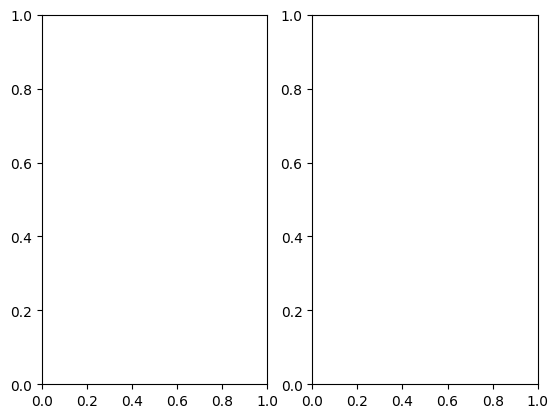

In [113]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [116]:
# predicting on test data.
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)

305/305 [==============================] - 117s 383ms/step


,Predicted Labels,Actual Labels
0,angry,angry
1,happy,happy
2,sad,sad
3,angry,angry
4,happy,happy
5,neutral,happy
6,happy,happy
7,disgust,disgust
8,disgust,disgust
9,fear,fear


In [117]:
df0

,Predicted Labels,Actual Labels
0,angry,angry
1,happy,happy
2,sad,sad
3,angry,angry
4,happy,happy
...,...,...
9725,disgust,disgust
9726,neutral,disgust
9727,fear,fear
9728,fear,fear


Some plots of multi_model
______________________________________________


# Evalutation

Results of best model

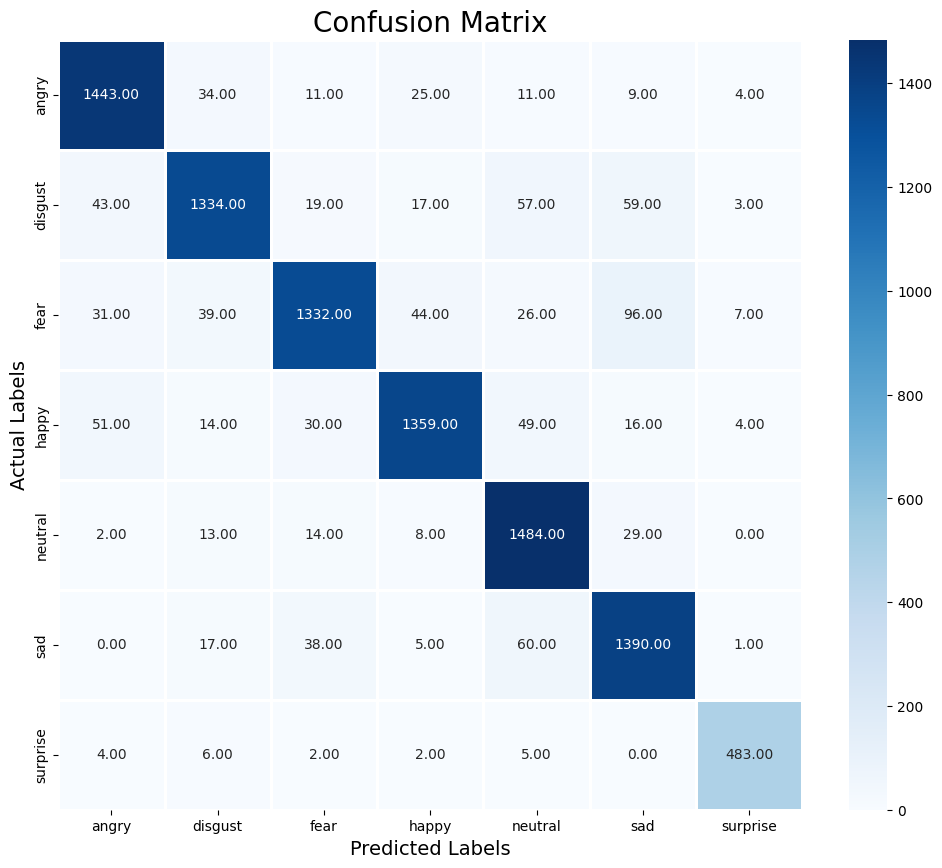

              precision    recall  f1-score   support

       angry       0.92      0.94      0.93      1537
     disgust       0.92      0.87      0.89      1532
        fear       0.92      0.85      0.88      1575
       happy       0.93      0.89      0.91      1523
     neutral       0.88      0.96      0.92      1550
         sad       0.87      0.92      0.89      1511
    surprise       0.96      0.96      0.96       502

    accuracy                           0.91      9730
   macro avg       0.91      0.91      0.91      9730
weighted avg       0.91      0.91      0.91      9730



In [118]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))

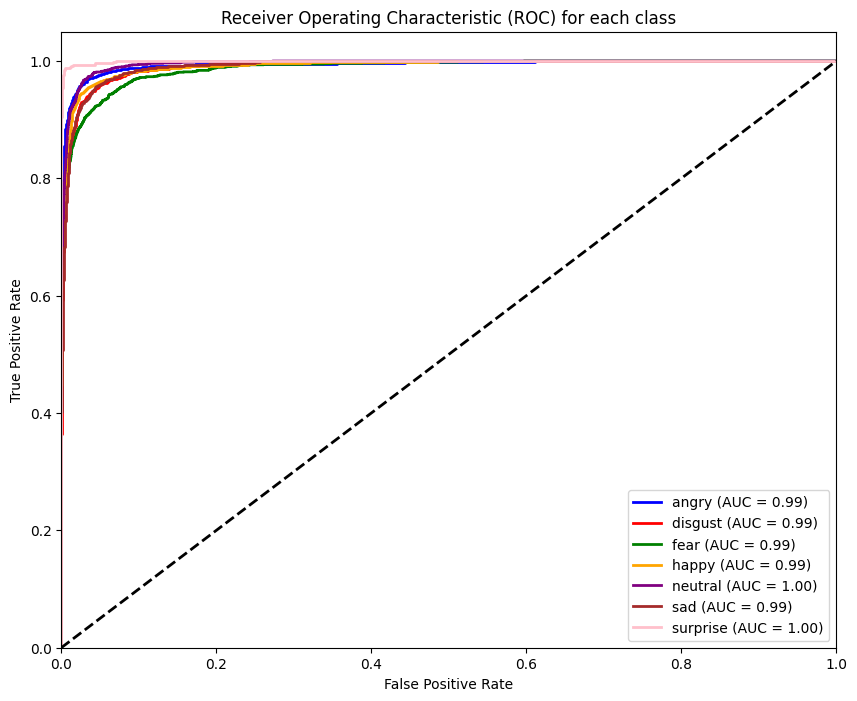

In [142]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

labels = encoder.categories_[0]
n_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_test0[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='{0} (AUC = {1:0.2f})'.format(labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for each class')
plt.legend(loc="lower right")
# plt.semilogy()
# plt.ylim(0.001, 1)
plt.show()



# Saving Best Model

In [119]:
# MLP for Pima Indians Dataset Serialize to JSON and HDF5
from tensorflow.keras.models import Sequential, model_from_json
model_json = model.to_json()
with open("CNN_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("CNN_model_weights.h5")
print("Saved model to disk") 

Saved model to disk


In [121]:
from tensorflow.keras.models import model_from_json


with open('CNN_model.json', 'r') as json_file:
    loaded_model_json = json_file.read()
    loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights("CNN_model_weights.h5")
print("Loaded model from disk")



Loaded model from disk


In [122]:
# loaded_model = tf.keras.models.load_model('CNN_model_weights.h5')
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn,y_test)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))


305/305 [==============================] - 116s 379ms/step - loss: 0.3034 - accuracy: 0.9070
accuracy: 90.70%
